Vladislav Ruskovoloshin <br>
05/11/20 <br>
CS661<br>
Final Project <br>

I did my project on artificial immune systems. I used the aiNet algorithm. Here is a link to best resource I found for how aiNet works.
https://pdfs.semanticscholar.org/6ef4/65d390b511c45e87e13cd3819065fccd59bf.pdf

Algorithm will contain a set of antibodies that will describe the “self” or data.User will provide number of antibodies and it will automatically cover data. It does this by selecting a random set of antibodies and everytime you give it a piece of data (antigen, basically a virus or bacteria)  it will mutate the antibodies that match to that piece of data. The mutated antibodies, clones, will be tested. If they match up to closely with other antibodies they get removed, and if they don’t match enough with the data (antigen) they will not be used.
After that the clones are put back into the antibody population. The antibody population will be tested to see if any antibodies match to closely with other antibodies. If they do the antibody that has been matched the least will be removed. This goes on for all the antigens (data). This is an example of the idiotypic network where antibodies have the ability to match with both antigens and other antibodies.
When all antigens have been tested the data will be effectively represented by the antibodies. My algorithm calculates suppress distance (distance where antibodies matched will be removed) on its own and it modifies it in real time depending on the antibody population size.

This is perfect for supervised classification, however more work would need to be done to my algorithm to make it work for unsupervised classification. 


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, read_csv, to_numeric, concat
from sklearn import cluster
import random as rand
np.random.seed(1)
import math

AVERAGE_AFFINITY = 0 # constant used for mutation
num_avg_affinities = 0
ITERATIONS = 0
SUPRESSDISTANCE = 0
GREATESTVAL = 0
SMALLESTVAL = 0
SQUARESIZE = 0

def makeHeader(values):
    theList = []
    for i in range(values):
        theList.append(str(i))
    return theList

header = makeHeader(9)
data = read_csv('s3.txt', delim_whitespace=True, names=header)
result = read_csv('result.txt', delim_whitespace=True)




def deleteBadData(data):
    index = 0
    header = 0
    while index < (len(data.iloc[0])):
        if np.isnan(data.iloc[0][index]):
            del data[str(header)]
        else:
            index+=1
        header+=1
    return data
            
data = deleteBadData(data)

combine = [data,result]
combined = pd.concat(combine,axis=1)
data2 = combined.loc[combined['result'] > 1]
virusData = combined.loc[combined['result'] == 1]
data2 = data2.reset_index(drop=True)
virusData = virusData.reset_index(drop=True)
resultVirus = virusData[['result']].copy()

del data2['result']
del virusData['result']
#data = data2
data2 =data2.astype('int')

def checkData(data):
    for i in range(len(data)):
        if np.isnan(data.iloc[i][0]) or np.isnan(data.iloc[i][1]):
            print(i)
        

# takes all data and selects random instances to produce
# a antibody population
def makeSubset(antibodies,numInstances):
    global GREATESTVAL
    global SMALLESTVAL
    data = antibodies.copy()
#    res = result.copy()
    randomList = rand.sample(range(0, len(antibodies)), numInstances)
    Ab = DataFrame()
#    r = DataFrame()
    for i in range(len(randomList)):
        for j in range(len(data.iloc[randomList[i]])):
            value = data.iloc[randomList[i]][j]
            if value > GREATESTVAL:
                GREATESTVAL = value
            elif i == 0 or value < SMALLESTVAL:
                SMALLESTVAL = value
        Ab = Ab.append(data.iloc[randomList[i]],ignore_index = True)
    return Ab


def makeSubset2(antibodies,numInstances):
    data = antibodies.copy()
    randomList = rand.sample(range(0, len(antibodies)), numInstances)
    Ab = DataFrame()
    for i in range(len(randomList)):
        for j in range(len(data.iloc[randomList[i]])):
            value = data.iloc[randomList[i]][j]
    
        Ab = Ab.append(data.iloc[randomList[i]],ignore_index = True)
    return Ab

def distance(a,b):
    dist = 0
    for i in range(len(a)):
        dist += abs(a[i] - b[i])
        
    return dist

#Antibodies = makeSubset(data,100)

def makeDistanceSquares():
    global GREATESTVAL
    global SMALLESTVAL
    global SQUARESIZE
#    print("GREATEST: " + str(GREATESTVAL))
#    print("SMALLEST: " + str(SMALLESTVAL))    
    SQUARESIZE = int((GREATESTVAL - SMALLESTVAL)/8)
    squareDistanceMat = []
    numDistSquareMat = []
    for i in range(16):
        squareDistanceMat.append([])
        numDistSquareMat.append([])        
        for j in range(16):
            squareDistanceMat[i].append([])
            numDistSquareMat[i].append([0])            
            
    return squareDistanceMat,numDistSquareMat
            
def placeValuesDistanceSquares(data,distanceSquares,distanceSquares2):
    global SMALLESTVAL
    global SQUARESIZE
    numSquares = len(distanceSquares)
    smallestPoint = SMALLESTVAL - (4*SQUARESIZE)
    numFeatures = len(data.iloc[0])
    x = 0
    y = 0
    for i in range(len(data)):

        x = int(math.floor((data.iloc[i][0] - smallestPoint)/SQUARESIZE))
        y = int(math.floor((data.iloc[i][1] - smallestPoint)/SQUARESIZE))
        if x < 0:
            x = 0
        if y < 0:
            y = 0
        if x >= numSquares:
            x = numSquares - 1
        if y >= numSquares:
            y = numSquares - 1
        if x >= 0 and y >= 0 and x < numSquares and y < numSquares:        
            distanceSquares[x][y].append(data.iloc[i])
            distanceSquares2[x][y][0] += 1
        else:
            print("X: " + str(x))
            print("Y: " + str(y))
            print("error")
        
    return distanceSquares, distanceSquares2,smallestPoint


def checkData(distanceSquares,distanceSquares2,antibodies,smallestPoint,antiMatch):
    global SQUARESIZE    
    i = len(antibodies) - 1
    while i >= 0:
        deleteLower = False
        goodAntiIndex = len(antibodies) - 1
#        x1 = int(math.floor((antibodies.iloc[i][0] - smallestPoint)/SQUARESIZE))
#        y2 = int(math.floor((antibodies.iloc[i][1] - smallestPoint)/SQUARESIZE))            
        toSimilar,x,y,anti,x1,y1 = checkBoxes(distanceSquares,distanceSquares2,antibodies.iloc[i],smallestPoint)
        if toSimilar:
            iTemp = i
            goodAntiIndex = findAntiIndex(anti,antibodies)
            deletedAntibodyIndex = 0
            if antiMatch[goodAntiIndex] < antiMatch[i]:
                if goodAntiIndex >= 0:                
                    antiMatch[i] += antiMatch[goodAntiIndex] + 1
                else:
                    print("?")
                iTemp = goodAntiIndex
                deletedAntibodyIndex = deleteSameInstanceBox(distanceSquares[x1][y1],anti)
                deleteLower= True
                x=x1
                y=y1
                del antiMatch[goodAntiIndex]
            else:               
                deleteLower = False
                deletedAntibodyIndex = deleteSameInstanceBox(distanceSquares[x][y],antibodies.iloc[i])
                if goodAntiIndex >= 0:
                    antiMatch[goodAntiIndex] += antiMatch[i]
                else:
                    print("?")
                del antiMatch[i]                     
            if deletedAntibodyIndex != -1:
                del distanceSquares[x][y][deletedAntibodyIndex]
                distanceSquares2[x][y][0] -= 1
                antibodies = antibodies.drop([iTemp],axis=0)
                antibodies = antibodies.reset_index(drop=True)
            else:
#                print(antibodies.iloc[i])
#                print(distanceSquares[x][y])
                print("error occured")
        if i > goodAntiIndex and deleteLower == True:
            i -= 2
        else:
            i -= 1
    return antibodies,distanceSquares,distanceSquares2,antiMatch

def findAntiIndex(anti,antibodies):
    for i in range(len(antibodies)):
        if distance(anti,antibodies.iloc[i]) == 0:
            return i
    return -1

def checkBoxes(distanceSquares,distanceSquares2,data,smallestPoint):
    global SQUARESIZE
    global SUPRESSDISTANCE
    numSquares = len(distanceSquares)
    x = int(math.floor((data[0] - smallestPoint)/SQUARESIZE))
    y = int(math.floor((data[1] - smallestPoint)/SQUARESIZE))
    if x < 0:
        x = 0
    if y < 0:
        y = 0
    if x >= numSquares:
        x = numSquares - 1
    if y >= numSquares:
        y = numSquares - 1    
    x1 = 0
    y1 = 0
    shortestDistance = SUPRESSDISTANCE + 1
    bestanti = -1
    found = False
    aList = [0,-1,1]
    for i in range(len(aList)):
        for j in range(len(aList)):
            tempX = aList[i] + x
            tempY = aList[j] + y
            if tempX >= 0 and tempY >= 0 and tempX < numSquares and tempY < numSquares:
                if distanceSquares2[tempX][tempY][0] > 0:
                    foundTemp,distance,anti = checkBox(distanceSquares[tempX][tempY],data)
                    if foundTemp and distance < shortestDistance:
                        x1 = tempX
                        y1 = tempY
                        bestanti = anti
                        found = True

    return found,x,y,bestanti,x1,y1

def checkBox(box,data):
    global SUPRESSDISTANCE
    bestMatch = -1
    shortestDistance = SUPRESSDISTANCE + 1
    found = False
    for i in range(len(box)):
        tempDistance = distance(data,box[i])
        if tempDistance != 0 and tempDistance < SUPRESSDISTANCE and tempDistance < shortestDistance:
            shortestDistance = tempDistance
            bestMatch = box[i]
            found = True
    return found,shortestDistance,bestMatch

def deleteSameInstanceBox(Box,data):
    for i in range(len(Box)):
        if distance(Box[i],data) == 0:
            return i
    return -1

def combineDataFrame(antibodies,clones):    
    numClones = len(clones)
    numAntibodies = len(antibodies)
    for i in range(numClones):
        alist = []
        for j in range(len(clones.iloc[0])):
            alist.append(clones.iloc[i][j])
        antibodies.loc[numAntibodies]=alist
        numAntibodies+=1

    return antibodies

    
# calculates affinity between a and b
def affinity(a,b):
    distance = 0
    for i in range(len(a)):
        dist = abs(a[i] - b[i])
        if dist != 0:
            distance += dist
        else:
            distance += 0.5
    return float(1/distance)

# calculates F affinity vector for antigen and all antibodies
def fAffinity(antigen,antibodies):
    numAb = len(antibodies)
    f = []
    for i in range(numAb):
        f.append(affinity(antigen,antibodies.iloc[i]))   
    return f

# chooses a subset of antibodies with highest affinity
# towards antigen
# returns both highest affinity list and affinity
def chooseAntibodies(antigen,antibodies,percent,antibodyMatches): 
    f = fAffinity(antigen,antibodies)
    numAntibodies = int(percent*len(antibodies))
    indexList = list(range(0,len(f)))
    
#    print(f)
    
    fPlusIndex = dict(zip(f,indexList))
    fPlusIndex = sorted(fPlusIndex.items(), key = lambda x: x[0])
    
#    print(fPlusIndex)
    
    Abn = DataFrame() # subset of high affinity antibodies
    newF = []
#    avgAffinity = 0
#    print(len(fPlusIndex))
#    print(len(f))
    bestF = fPlusIndex[len(fPlusIndex)-1][0]
    for i in range(numAntibodies):
#        avgAffinity += fPlusIndex[len(f)-i-1][0]
        index = fPlusIndex[len(fPlusIndex)-i-1][1]
        if len(antibodyMatches) >= len(antibodies):
            antibodyMatches[index] += (bestF  - fPlusIndex[len(fPlusIndex)-i-1][0])/ bestF
#        if len(antibodyMatches) >= len(antibodies) and i == 0:
#            antibodyMatches[index] += 1
        Abn = Abn.append(antibodies.iloc[index],ignore_index = True)
        newF.append(fPlusIndex[len(fPlusIndex)-i-1][0])
        
#    avgAffinity = avgAffinity/numAntibodies
#    calculateAvgAffinity(avgAffinity)
    return Abn,newF

# function for measuring affinity which is weighted towards newer instances
# not currently in use
def calculateAvgAffinity(avgAffinity):
    global AVERAGE_AFFINITY    
    global num_avg_affinities
    num_avg_affinities += 1
    if AVERAGE_AFFINITY == 0:
        AVERAGE_AFFINITY = avgAffinity
    elif num_avg_affinities < 10:
        AVERAGE_AFFINITY = ((AVERAGE_AFFINITY*(num_avg_affinities - 1))+avgAFfinity)/num_avg_affinities
    else:
        AVERAGE_AFFINITY = ((AVERAGE_AFFINITY*9)+avgAFfinity)/10


Iteration: 0
Number antibodies: 100

square Size: 94023
Suppress distance: 12152.32438016529
END OF ITERATION


Iteration: 1
Number antibodies: 94

square Size: 94023
Suppress distance: 10937.091942148762
END OF ITERATION


Iteration: 2
Number antibodies: 95

square Size: 94023
Suppress distance: 9843.382747933885
END OF ITERATION


Iteration: 3
Number antibodies: 98



C:\Users\V\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars


square Size: 94023
Suppress distance: 8859.044473140497
END OF ITERATION


Iteration: 4
Number antibodies: 98

square Size: 94023
Suppress distance: 7973.1400258264475
END OF ITERATION


Iteration: 5
Number antibodies: 99

square Size: 94023
Suppress distance: 7175.826023243803
END OF ITERATION


Iteration: 6
Number antibodies: 100

square Size: 94023
Suppress distance: 6458.243420919423
END OF ITERATION


Iteration: 7
Number antibodies: 102

square Size: 94023
Suppress distance: 5812.419078827481
END OF ITERATION


Iteration: 8
Number antibodies: 104

square Size: 94023
Suppress distance: 5231.177170944733
END OF ITERATION


Iteration: 9
Number antibodies: 105

square Size: 94023
Suppress distance: 4708.05945385026
END OF ITERATION


Iteration: 10
Number antibodies: 107

square Size: 94023
Suppress distance: 4237.2535084652345
END OF ITERATION


Iteration: 11
Number antibodies: 110

square Size: 94023
Suppress distance: 4237.2535084652345
END OF ITERATION


Iteration: 12
Number antibo

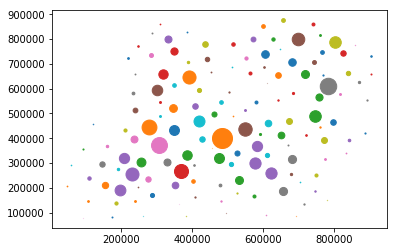

Regular Plot


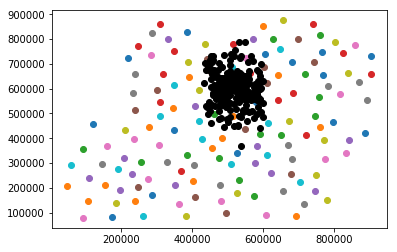

The error: 0.5322
nonVirus error: 0.5625531914893617
virus error: 0.056666666666666664


In [14]:
def mutateAntibody(antigen,antibody):
    mutatedAntibody = []
    for i in range(len(antibody)):
        randVal = (((np.random.uniform(-0.8,0.89))**3) + 0.2)/0.85
        mutatedAntibody.append(antibody[i] + int((antigen[i] - antibody[i])*randVal))
    return mutatedAntibody

def makeMutatedList(antigen, matchedAntibodies):
    mutatedMatches = []
    for i in range(len(matchedAntibodies)):
        mutatedMatches.append(mutateAntibody(antigen,matchedAntibodies[i]))

# test function for mutate antibody function
# not used
def mutateMeanVar(antigen,antibody):
    total = [0,0]
    for i in range(100):
        temp = mutateAntibody(antigen,antibody)
        print(temp)
        total[0] += temp[0]
        total[1] += temp[1]
        
    total[0] = total[0]/100
    total[1] = total[1]/100
    return total

def createCloneMatrix(antigen,antibodies,f):
    worstAffinVal = f[len(f)-1]
    bestAffinVal = f[0]
    cloneArray = DataFrame()
    for i in range(len(antibodies)):
        numberClones = int(f[i]/(worstAffinVal/2))
        if numberClones > 20:
            numberClones = 20
        for j in range(numberClones):
            clonedAntibody = mutateAntibody(antigen,antibodies.iloc[i])
            cloneArray = cloneArray.append([clonedAntibody],ignore_index = True)
    cloneArray = cloneArray.reset_index(drop=True)
    return cloneArray
    
def selectFromCloneMatrix(antigen,C,percent):
    highestAnti,fAffinityList = chooseAntibodies(antigen,C,percent,[0])
    return highestAnti, fAffinityList

def removeClones(clones,bestAntibodies,percent):
    numberAntiTested = int(percent*len(bestAntibodies))
    if numberAntiTested == 0 and len(bestAntibodies) > 0:
        numberAntiTested = 1
    numFeatures = len(bestAntibodies.iloc[0])
    deathDistance = 0
    # determine a death distance based on best 3 antibodies
    for i in range(numberAntiTested):
        for j in range(numFeatures):
            deathDistance += bestAntibodies.iloc[i][j]
    if numberAntiTested != 0:        
        deathDistance = deathDistance/numberAntiTested
#    print(deathDistance)
    
    removeList = []
    for i in range(len(clones)):
        cloneDistance = 0
        for j in range(numFeatures):
            cloneDistance += clones.iloc[i][j]
#        print(cloneDistance)
        if deathDistance < cloneDistance:
            removeList.append(i)
            
    if len(removeList) == len(clones) and len(clones) > 0:
        if len(removeList) > 3:
            removeList = removeList[3:]
        else:
            removeList = removeList[1:]
    clones = clones.drop(removeList,axis=0)
    clones = clones.reset_index(drop=True)      
    return clones
    

def cloneAffinityMatrix(clones):
    global ITERATIONS
    global SUPRESSDISTANCE
    
    numClones = len(clones)
    cloneAffinMat = []
    avgDist= 0
    for i in range(numClones):
        distArray, dist = distances(i, clones)
        cloneAffinMat.append(distArray)
        avgDist += dist
    avgDist = avgDist/(numClones-1)
    
    if ITERATIONS == 0:
        SUPRESSDISTANCE = avgDist/2

    return cloneAffinMat,avgDist
    
        
def distances(index,antibodies):
    distanceArray = [0]*len(antibodies)
    avgDist = 0
    for i in range(len(antibodies)):
        for j in range(len(antibodies.iloc[0])):
            dist = abs(antibodies.iloc[index][j] - antibodies.iloc[i][j])
            distanceArray[i] += dist
            avgDist += dist
    avgDist = avgDist/(len(antibodies) - 1)
    return distanceArray,avgDist


            
    
def supressClones(clones,cloneAffinMat):
    global ITERATIONS
    global SUPRESSDISTANCE
#    clones = clones.reset_index()
    numClones = len(clones)
#    print(numClones)
    supressionDist = SUPRESSDISTANCE
    
    if ITERATIONS == 0:
        supressionDist = (SUPRESSDISTANCE*5)/2
    ITERATIONS+=1
    
    removeList = []
    fullList = [0]*numClones
    for i in range(numClones):
        for j in range(numClones):
            if fullList[j] == 0 and cloneAffinMat[i][j] < supressionDist and i != j and len(removeList) < (numClones-2):
                fullList[j] = 1
                removeList.append(j)
    clones = clones.drop(removeList,axis=0)
    clones = clones.reset_index(drop=True)  

    return clones
                
def addClones(antibodies,clones,numberMatches):    
    numClones = len(clones)
    numAntibodies = len(antibodies)
    for i in range(numClones):
        alist = []
        for j in range(len(clones.iloc[0])):
            alist.append(clones.iloc[i][j])
        antibodies.loc[numAntibodies]=alist
        numberMatches.append(1.0)
        numAntibodies+=1

    return antibodies,numberMatches

def supressAntibodies(antibodies):
    global SUPRESSDISTANCE
    global ITERATIONS

    if ITERATIONS == 0:
        supressionDist = (SUPRESSDISTANCE*5)/2
    else:
        supressionDist = SUPRESSDISTANCE
    
    numAntibodies = len(antibodies)
    removeList = []
    fullList = [0]*numAntibodies
    for i in range(int(numAntibodies/2) + 1):
        for j in range(numAntibodies):
            tempDist = 0
            if i != j:
                tempDist = distance(antibodies.iloc[i],antibodies.iloc[j])
            if fullList[j] == 0 and tempDist < supressionDist and i != j:
                fullList[j] = 1
                removeList.append(j)
                
    antibodies = antibodies.drop(removeList,axis=0)
    antibodies = antibodies.reset_index(drop=True) 
    
    return antibodies
    
def updateSupressDistance(antibodies,number):
    global SUPRESSDISTANCE
    global SQUARESIZE
    print("square Size: "+ str(SQUARESIZE))
    numAntibodies = len(antibodies)    
    if numAntibodies*0.9 < number:
        SUPRESSDISTANCE = SUPRESSDISTANCE*0.9
    elif numAntibodies > (number*1.5) and (SQUARESIZE*1.5) >= SUPRESSDISTANCE:
        SUPRESSDISTANCE = SUPRESSDISTANCE*1.25
    print("Suppress distance: " + str(SUPRESSDISTANCE))
    return SUPRESSDISTANCE
    
    
def aiNet(data):
    numAntiStart = 100
    suppressDist = 0
    Antibodies = makeSubset(data,numAntiStart)
    numberMatches = [0.5]*numAntiStart
    d1,d2 = makeDistanceSquares()
    d1,d2,smallestPoint = placeValuesDistanceSquares(Antibodies,d1,d2)    
    data = makeSubset2(data,len(data))    
    numData = len(data)
    for i in range(numData):
        print()
        print("Iteration: " + str(i))
        print("Number antibodies: " + str(len(Antibodies)))
        print()
        AbM, f = chooseAntibodies(data.iloc[i],Antibodies,0.1,numberMatches)
        C = createCloneMatrix(data.iloc[i],AbM,f)

        CMaturated, f = selectFromCloneMatrix(data.iloc[i],C,0.5)

        CApoptosis = removeClones(CMaturated,AbM,0.2)

        cAffinMatrix,avg = cloneAffinityMatrix(CApoptosis)
        C = supressClones(CApoptosis,cAffinMatrix)

        if len(C) > 0:
            d1,d2,uselessVale = placeValuesDistanceSquares(C,d1,d2)
        
        Antibodies,numberMatches = addClones(Antibodies,C,numberMatches)
        
        

        Antibodies['matches'] = numberMatches # RANDOMIZE DATA
        Antibodies = Antibodies.sample(frac=1)
        Antibodies = Antibodies.reset_index(drop=True)
        matchDataframe = Antibodies[['matches']].copy()
        del Antibodies['matches']
        numberMatches = []
        deathRate = 0.01
        for i in range(len(matchDataframe)):
            value = matchDataframe.iloc[i][0]
            if value > (deathRate*2):
                numberMatches.append(value-deathRate)
            else:
                numberMatches.append(0.03)        
                
                
        Antibodies,d1,d2,numberMatches = checkData(d1,d2,Antibodies,smallestPoint,numberMatches)
        suppressDist = updateSupressDistance(Antibodies,numAntiStart)
        print("END OF ITERATION")
        print()
    return Antibodies,numberMatches, suppressDist
        

def graphAntibodies(antibodies,numberMatches,virus):
    maximum = 0
    for i in range(len(numberMatches)):
        if numberMatches[i] > maximum:
            maximum = numberMatches[i]
    
    print()
    print("max match value: " + str(maximum))
    for i in range(len(antibodies)):
        plt.plot(antibodies.iloc[i][0],antibodies.iloc[i][1],'o',markersize=((numberMatches[i]/maximum)*20))
    plt.show()
    
    print("Regular Plot")
    for i in range(len(antibodies)):
        plt.plot(antibodies.iloc[i][0],antibodies.iloc[i][1],'o')
        
    for i in range(len(virus)):
        plt.plot(virus.iloc[i][0],virus.iloc[i][1],'o',color="black")
    plt.show()    
    return maximum
    
    

antibodiesOfData,numberMatches,supressDist = aiNet(data2)
maximum = graphAntibodies(antibodiesOfData,numberMatches,virusData)

def testVirus(anti,virus,suppress,numMatch,maximum):
    result = []
    for i in range(len(virus)):
        found = False
        for j in range(len(anti)):
            if distance(anti.iloc[j],virus.iloc[i]) < (suppress*numMatch[j]*1.3/maximum):
                result.append(0)
                found = True
                break
        if found == False:
            result.append(1)
    return result

def error(res,virus):
    falsePostive = 0
    falseNegative = 0
    totalVirus = 0
    wrong = 0
    for i in range(len(res)):
        if virus.iloc[i][0] == 1:
            totalVirus += 1
        if res[i] == 1 and virus.iloc[i][0] != 1:
            falsePostive += 1
            wrong +=1
        elif res[i] != 1 and virus.iloc[i][0] == 1:
            falseNegative += 1
            wrong += 1
    return wrong/len(res), falsePostive/(len(res) - totalVirus),falseNegative/totalVirus

error, fp,fn = error(testVirus(antibodiesOfData,data,supressDist,numberMatches,maximum),result)

print("The error: " + str(error))
print("nonVirus error: " + str(fp))
print("virus error: " + str(fn))